In [1]:
#  Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [3]:
# Importing the dataset
df= pd.read_csv('dataset.csv', encoding='latin1')
df

,numer_sta,date,lat,lon,Temperature,Humidity,Wind speed,Pressure,Wave height,Wave period,Storm,storm name
0,62163,1/1/1996,47.5,-8.5,285.249334,87.471219,6.931818,99436.48589,4.336735,9.494752,0,NaN
1,62163,1/2/1996,47.5,-8.5,286.219464,88.826087,7.457478,101116.52170,3.452174,8.236621,0,NaN
2,62163,1/3/1996,47.5,-8.5,286.628267,89.209170,11.875000,100714.26900,4.400000,7.744227,0,NaN
3,62163,1/4/1996,47.5,-8.5,285.677647,88.564218,7.670588,99640.00000,3.805882,8.000000,0,NaN
4,62163,1/5/1996,47.5,-8.5,285.065882,83.692654,10.820235,99380.31641,4.571069,8.052032,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9127,62163,12/27/2020,47.5,-8.5,283.741667,77.500000,21.475000,99274.58333,8.400000,10.083333,1,bella
9128,62163,12/28/2020,47.5,-8.5,283.783333,71.750000,21.462500,99166.25000,9.454167,11.083333,1,bella
9129,62163,12/29/2020,47.5,-8.5,282.641667,66.583333,13.387500,100402.91670,6.312500,9.000000,0,NaN
9130,62163,12/30/2020,47.5,-8.5,283.770833,79.291667,9.808333,101017.08330,3.450000,7.000000,0,NaN


In [4]:
df = df.drop(['numer_sta', 'lat', 'lon', 'storm name'], axis=1)

df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")
df

,Temperature,Humidity,Wind speed,Pressure,Wave height,Wave period,Storm
date,,,,,,,
1996-01-01,285.249334,87.471219,6.931818,99436.48589,4.336735,9.494752,0
1996-01-02,286.219464,88.826087,7.457478,101116.52170,3.452174,8.236621,0
1996-01-03,286.628267,89.209170,11.875000,100714.26900,4.400000,7.744227,0
1996-01-04,285.677647,88.564218,7.670588,99640.00000,3.805882,8.000000,0
1996-01-05,285.065882,83.692654,10.820235,99380.31641,4.571069,8.052032,0
...,...,...,...,...,...,...,...
2020-12-27,283.741667,77.500000,21.475000,99274.58333,8.400000,10.083333,1
2020-12-28,283.783333,71.750000,21.462500,99166.25000,9.454167,11.083333,1
2020-12-29,282.641667,66.583333,13.387500,100402.91670,6.312500,9.000000,0


In [5]:
# Dealing with missing values
print(df.isnull().sum())

Temperature     96
Humidity        97
Wind speed      87
Pressure        74
Wave height     94
Wave period    126
Storm            0
dtype: int64


In [6]:
from sklearn.impute import SimpleImputer

# Create an imputer object using median as the strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Define the columns where you want to apply the imputation
columns_to_impute = ['Temperature',	'Humidity',	'Wind speed',	'Pressure', 'Wave height', 'Wave period']

# Apply the imputer to the selected columns of the DataFrame
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Checking the DataFrame to ensure no more missing values
df.isnull().values.any()

False

In [7]:
# Split the data into training and testing dataset
train_size = int(len(df) * 0.80)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print("train data: ", len(train))
print("test data:", len(test))

train data:  7305
test data: 1827


In [ ]:
X_train, y_train = train.iloc[:, [0,1,2,3,4,5]].values, train.iloc[:,6].values
X_test, y_test = test.iloc[:, [0,1,2,3,4,5]].values, test.iloc[:,6].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7305, 6), (7305,), (1827, 6), (1827,))

In [9]:
# Normalization
temp_training_mean = np.mean(X_train[:, 0])
temp_training_std = np.std(X_train[:, 0])

hum_training_mean = np.mean(X_train[:, 1])
hum_training_std = np.std(X_train[:, 1])

wind_training_mean = np.mean(X_train[:, 2])
wind_training_std = np.std(X_train[:, 2])

pres_training_mean = np.mean(X_train[:, 3])
pres_training_std = np.std(X_train[:, 3])

waveH_training_mean = np.mean(X_train[:, 4])
waveH_training_std = np.std(X_train[:, 4])

waveP_training_mean = np.mean(X_train[:, 5])
waveP_training_std = np.std(X_train[:, 5])

def preprocess(X):
  X[:, 0] = (X[:, 0] - temp_training_mean) / temp_training_std
  X[:, 1] = (X[:, 1] - hum_training_mean) / hum_training_std
  X[:, 2] = (X[:, 2] - wind_training_mean) / wind_training_std
  X[:, 3] = (X[:, 3] - pres_training_mean) / pres_training_std
  X[:, 4] = (X[:, 4] - waveH_training_mean) / waveH_training_std
  X[:, 4] = (X[:, 4] - waveP_training_mean) / waveP_training_std

In [10]:
preprocess(X_train)
preprocess(X_test)

In [11]:
# Model and performance evaluation
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [12]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1]),
    'max_depth' : hp.choice('max_depth', range(3,13,1)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [13]:
def objective(params):

    xgboost = XGBClassifier(seed=0, **params)
    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='recall', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = bayes_trials)

100%|██████████| 50/50 [00:09<00:00,  5.25trial/s, best loss: -1.0]              


In [14]:
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

{'colsample_bytree': 3, 'gamma': 4, 'learning_rate': 3, 'max_depth': 1, 'reg_alpha': 3, 'reg_lambda': 1}
{'colsample_bytree': 0.6, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 0.01}


In [15]:
# Train model using the best parameters
xgboost_bo = XGBClassifier(seed=0,
                           colsample_bytree=0.4,
                           gamma=0.0,
                           learning_rate=0.1,
                           max_depth=12,
                           reg_alpha=1e-05,
                           reg_lambda=0.01
                           ).fit(X_train,y_train)

In [16]:
# Make prediction using the best model
preds = xgboost_bo.predict(X_test)

In [17]:
# Get performance metrics
precision, recall, fscore, support = score(y_test, preds)
# Print result
print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

The recall value for the xgboost Bayesian optimization is 1.0000


In [18]:
preds = pd.DataFrame(preds, columns=["storms_prediction"])
preds['Date'] = pd.date_range(start='01/01/2016', periods=len(preds), freq='D')
preds.Date = pd.to_datetime(preds.Date)
preds = preds.set_index("Date")

In [19]:
test = pd.concat([test,preds], axis=1)
test

,Temperature,Humidity,Wind speed,Pressure,Wave height,Wave period,Storm,storms_prediction
2016-01-01,284.475000,70.750000,11.037500,101790.00000,4.137500,9.166667,0,0
2016-01-02,285.358333,76.375000,10.862500,100370.83330,3.141667,9.458333,0,0
2016-01-03,284.475000,69.041667,16.337500,99231.66667,6.745833,8.708333,0,0
2016-01-04,283.987500,76.833333,15.070833,99602.50000,7.404167,9.791667,0,0
2016-01-05,285.270833,81.416667,12.375000,99680.83333,4.658333,9.583333,0,0
...,...,...,...,...,...,...,...,...
2020-12-27,283.741667,77.500000,21.475000,99274.58333,8.400000,10.083333,1,1
2020-12-28,283.783333,71.750000,21.462500,99166.25000,9.454167,11.083333,1,1
2020-12-29,282.641667,66.583333,13.387500,100402.91670,6.312500,9.000000,0,0
2020-12-30,283.770833,79.291667,9.808333,101017.08330,3.450000,7.000000,0,0


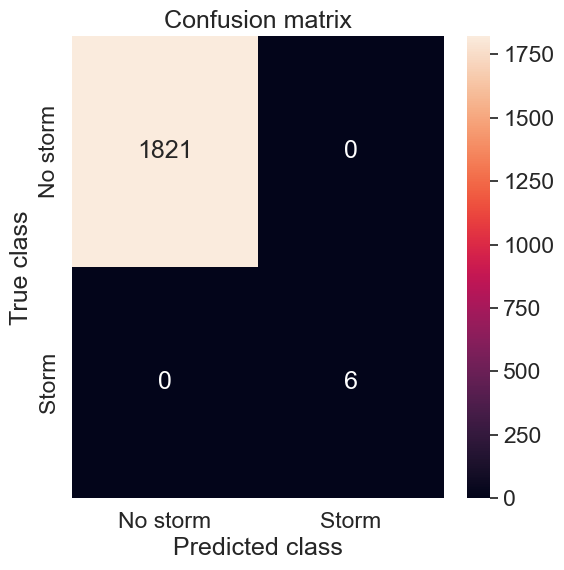

In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, preds)

LABELS = ["No storm","Storm"]

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [21]:
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: 6
True Negatives: 1821
False Positives: 0
False Negatives: 0


In [22]:
# calculate accuracy
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

# calculate mis-classification
conf_misclassification = 1- conf_accuracy

# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))

# calculate the specificity
conf_specificity = (TN / float(TN + FP))

# calculate precision
conf_precision = (TN / float(TN + FP))

# calculate f_1 score
conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))


print('-'*50)
print(f'Accuracy: {round(conf_accuracy,2)}')
print(f'Mis-Classification: {round(conf_misclassification,2)}')
print(f'Sensitivity: {round(conf_sensitivity,2)}')
print(f'Specificity: {round(conf_specificity,2)}')
print(f'Precision: {round(conf_precision,2)}')
print(f'f_1 Score: {round(conf_f1,2)}')

--------------------------------------------------
Accuracy: 1.0
Mis-Classification: 0.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 1.0


In [23]:
# Compute micro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

<Figure size 640x480 with 0 Axes>

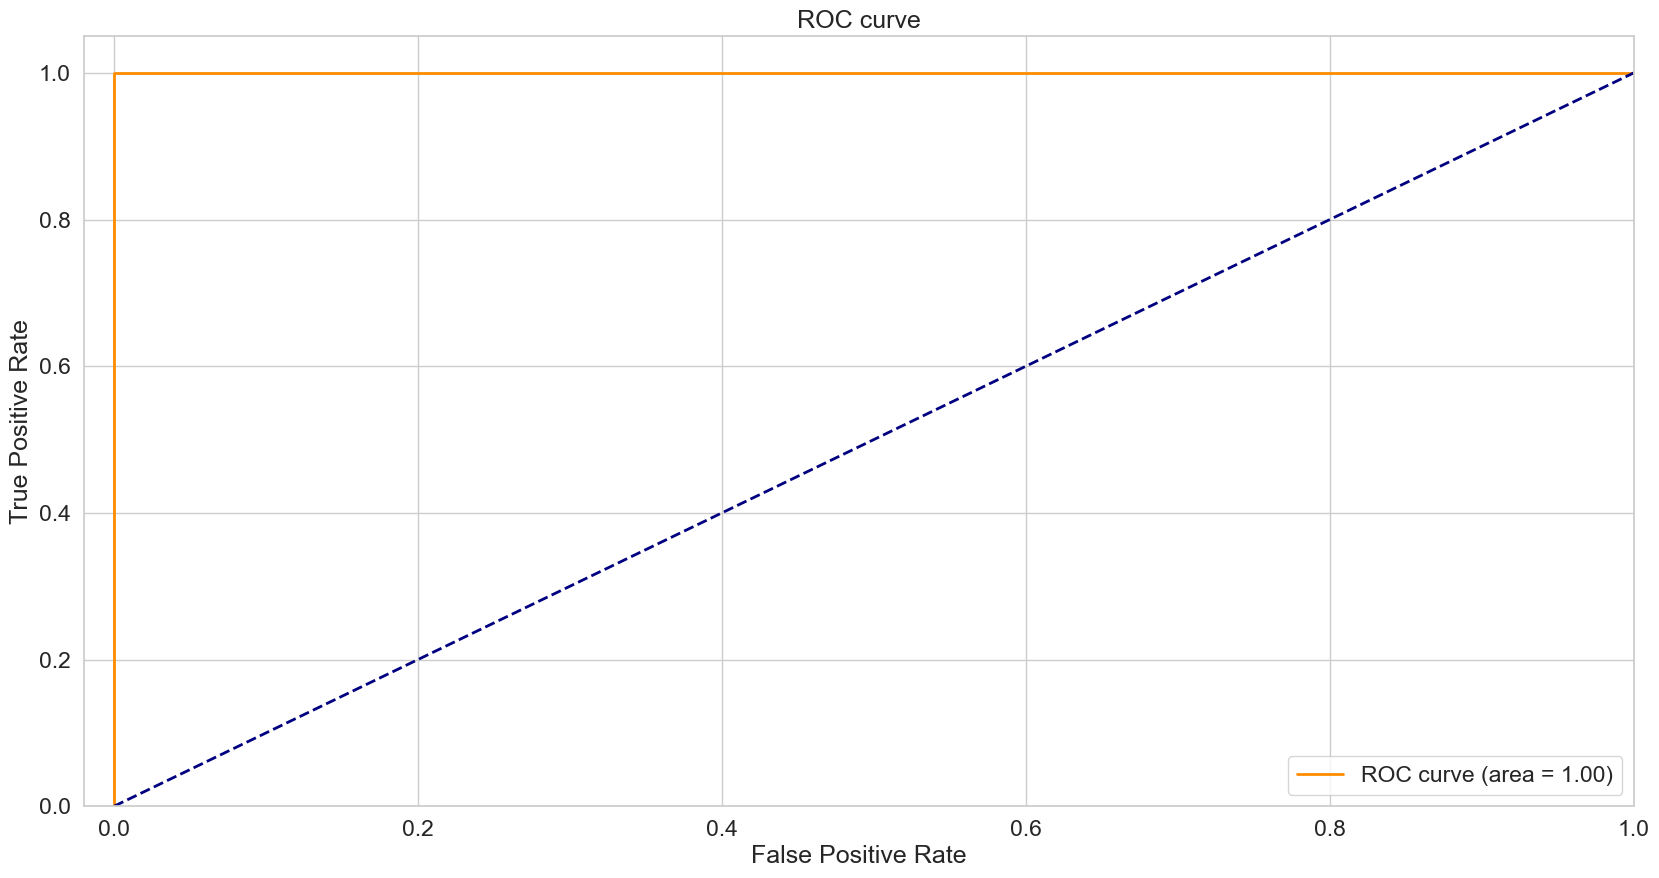

In [24]:
plt.figure()
plt.figure(figsize=(20,10))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

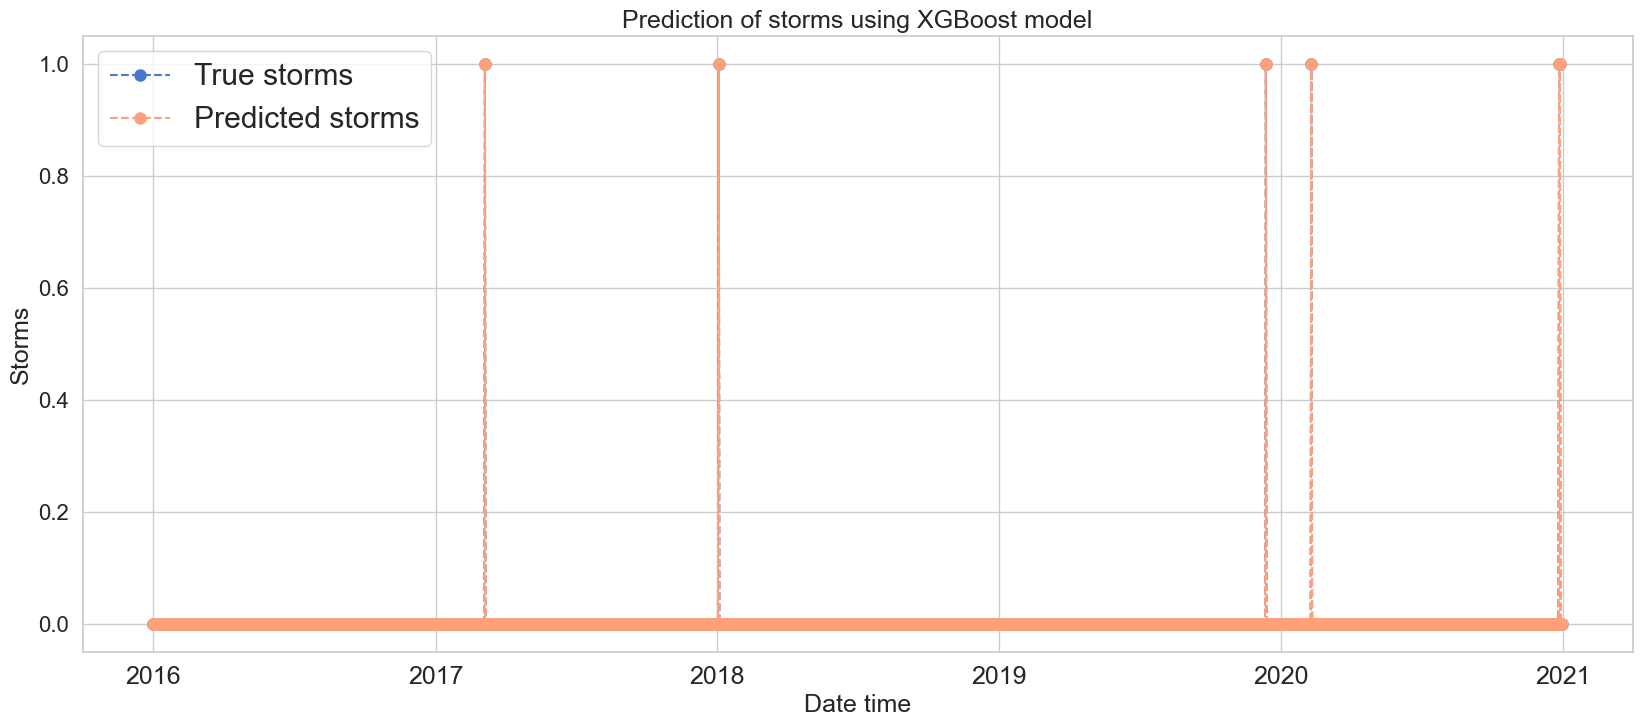

In [25]:
plt.figure(figsize=(20,8))
plt.plot(test.index, test['Storm'], color = 'b', label="True storms", marker='o', markersize=8, linestyle='dashed')
plt.plot(test.index, test['storms_prediction'], color = 'lightsalmon', label="Predicted storms", marker='o', markersize=8, linestyle='dashed')
plt.title('Prediction of storms using XGBoost model')
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Storms")
plt.show()